# Mean-variance optimisation

<!-- In this cookbook recipe, we work on several examples demonstrating PyPortfolioOpt's mean-variance capabilities. I will discuss what I think should be your "default" options, based on my experience in optimising portfolios. -->

이 쿡북 레시피에서는 PyPortfolioOpt의 평균 분산 기능을 보여주는 몇 가지 예제를 연구합니다. 포트폴리오 최적화 경험을 바탕으로 "기본" 옵션이 되어야한다고 생각하는 것이 무엇인지 논의하겠습니다.

<!-- To start, you need a list of tickers. Some people just provide the whole universe of stocks, but I don't think this is a good idea - portfolio optimisation is quite different from asset selection. I would suggest anywhere from 10-50 stocks as a starting point. -->

시작하려면 티커 목록이 필요합니다. 어떤 사람들은 주식의 전체 유니버스를 제공 할 뿐이지만 이것이 좋은 생각이라고 생각하지 않습니다. 포트폴리오 최적화는 자산 선택과는 상당히 다릅니다. 나는 시작점으로 10-50주식 중 어느 곳에서나 제안 할 것입니다.

<!-- Some of the things we cover:

- Downloading data and getting it into PyPortfolioOpt
- Calculating and visualising the covariance matrix
- Optimising a long/short portfolio to minimise total variance
- Optimising a portfolio to maximise the Sharpe ratio, subject to sector constraints
- Optimising a portfolio to maximise return for a given risk, subject to sector constraints, with an L2 regularisation objective
- Optimising a market-neutral portfolio to minimise risk for a given level of return
- Plotting the efficient frontier -->

우리가 다루는 몇 가지 사항 :

- 데이터 다운로드 및 PyPortfolioOpt로 가져 오기
- 공분산 행렬 계산 및 시각화
- 총 분산을 최소화하기 위해 롱/숏 포트폴리오 최적화
- 섹터 제약에 따라 Sharpe 비율을 최대화하기 위한 포트폴리오 최적화
- L2 정규화 목표를 사용하여 섹터 제약에 따라 주어진 위험에 대한 수익을 극대화하기 위해 포트폴리오 최적화
- 주어진 수익 수준에 대한 위험을 최소화하기 위해 시장 중립적 포트폴리오 최적화
- 효율적인 프론티어 플로팅

<!-- Please consult the [docs](https://pyportfolioopt.readthedocs.io/) for more info. -->
자세한 내용은 [문서](https://pyportfolioopt.readthedocs.io/) 를 참조하십시오.

## Downloading data

<!-- To download data, we will use `yfinance`, an excellent library that provides free price data from Yahoo Finance, no API key needed. -->

데이터를 다운로드하려면 API 키가 필요없는 Yahoo Finance의 무료 가격 데이터를 제공하는 우수한 라이브러리인 `yfinance`를 사용합니다.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA"] 

In [10]:
ohlc = yf.download(tickers, end="2020-09-01")# period="max")

[*********************100%***********************]  15 of 15 completed


In [11]:
prices = ohlc["Adj Close"]
prices.tail()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
2020-08-25,237.280869,3346.489990,344.048828,129.789993,6.94,65.365128,99.576004,47.525295,37.060001,347.255646,215.904755,36.071163,404.667999,310.938751,39.916946
2020-08-26,239.512115,3441.850098,343.609680,132.179993,6.82,64.919792,98.178963,47.773285,36.380001,350.611694,220.572525,35.733086,430.634003,307.552704,39.067440
2020-08-27,239.930481,3400.000000,345.695648,133.729996,6.91,64.870316,101.408989,47.842724,37.650002,355.585938,225.988358,35.554653,447.750000,310.391022,38.803802
2020-08-28,242.042221,3401.800049,347.701813,135.539993,6.94,64.583321,101.825127,49.429878,38.810001,365.694153,228.312271,35.601612,442.679993,313.079895,39.731419
2020-08-31,238.994141,3450.959961,346.993195,131.869995,6.82,66.057869,99.268852,49.132286,37.580002,357.773376,224.941086,35.488914,498.320007,311.267365,38.999088


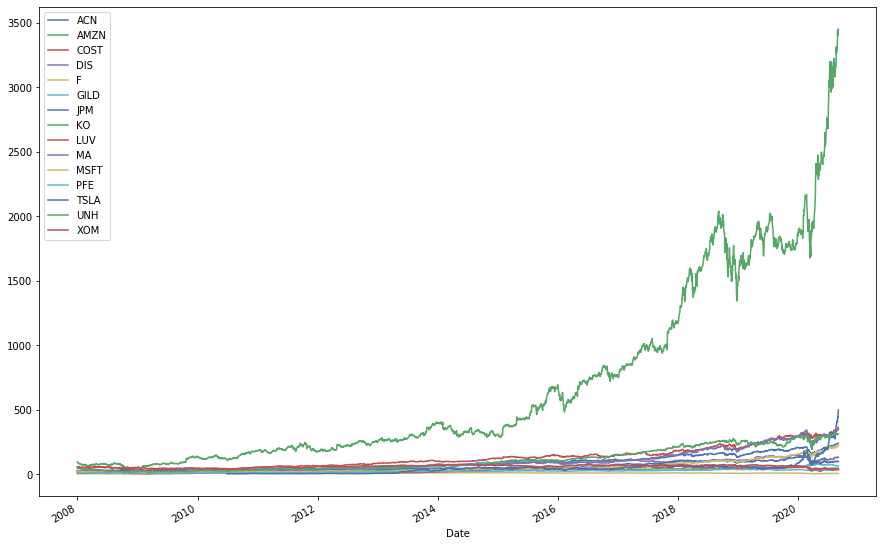

In [12]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

## Calculating the covariance matrix

In [13]:
import pypfopt
pypfopt.__version__

'1.2.7'

In [14]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
ACN,0.093101,0.045402,0.027579,0.041180,0.044124,0.030179,0.050221,0.020363,0.037121,0.045800,0.040785,0.026555,0.038645,0.030908,0.031404
AMZN,0.045402,0.347874,0.047966,0.056218,0.053453,0.062220,0.069724,0.020617,0.048742,0.057515,0.072397,0.033183,0.054143,0.035810,0.028026
COST,0.027579,0.047966,0.103878,0.032728,0.031600,0.028074,0.040050,0.021839,0.032320,0.033329,0.037204,0.026105,0.021722,0.027829,0.021283
DIS,0.041180,0.056218,0.032728,0.099509,0.040138,0.033636,0.047294,0.026311,0.038330,0.050043,0.043218,0.030075,0.039173,0.032755,0.025173
F,0.044124,0.053453,0.031600,0.040138,0.124628,0.030863,0.054440,0.026589,0.045027,0.064004,0.041669,0.027872,0.051121,0.029749,0.026879
GILD,0.030179,0.062220,0.028074,0.033636,0.030863,0.246924,0.044305,0.017132,0.032313,0.034861,0.036681,0.033487,0.034241,0.035147,0.021653
JPM,0.050221,0.069724,0.040050,0.047294,0.054440,0.044305,0.130800,0.027983,0.048713,0.073403,0.050876,0.033593,0.040914,0.039591,0.032518
KO,0.020363,0.020617,0.021839,0.026311,0.026589,0.017132,0.027983,0.058422,0.023279,0.026213,0.028784,0.026637,0.019759,0.023436,0.020727
LUV,0.037121,0.048742,0.032320,0.038330,0.045027,0.032313,0.048713,0.023279,0.139020,0.047627,0.037595,0.026710,0.037041,0.033549,0.022298
MA,0.045800,0.057515,0.033329,0.050043,0.064004,0.034861,0.073403,0.026213,0.047627,0.121470,0.049874,0.034202,0.045693,0.044920,0.043070


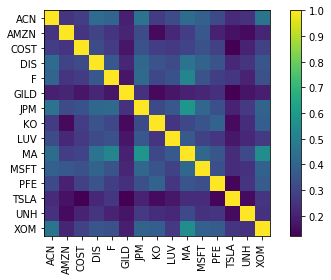

In [15]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

<!-- For reasons discussed in the docs, the sample covariance matrix should not be your default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal: -->

문서에서 논의 된 이유 때문에 샘플 공분산 행렬이 기본 선택이 되어서는 안됩니다. 더 나은 옵션은 공분산 행렬의 극한 값을 줄이는 Ledoit-Wolf 수축이라고 생각합니다. 아래 이미지에서 대각선 외부에 밝은 점이 더 적음을 알 수 있습니다.

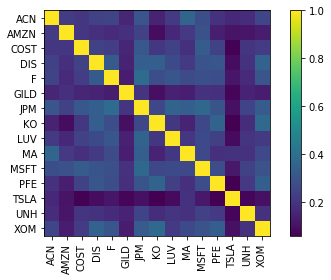

In [16]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

## Return estimation

<!-- As discussed in the docs, it is often a bad idea to provide returns using a simple estimate like the mean of past returns. Generally, unless you have a proprietary method for estimating returns, I would skip this altogether and just find the `min_volatility()` portfolio or use `HRP`.  -->

문서에서 논의했듯이 과거 수익률의 평균과 같은 간단한 추정치를 사용하여 수익을 제공하는 것은 종종 나쁜 생각입니다. 일반적으로 수익을 추정하는 독점적인 방법이 없는 경우에는 이를 모두 건너 뛰고 `min_volatility()` 포트폴리오를 찾거나 `HRP`를 사용합니다.

<!-- However, in this example we will use the CAPM returns, which aims to be slightly more stable than the default mean historical return. Please see the notebook `1-RiskReturnModels.ipynb` for more information. -->

그러나 이 예에서는 기본 평균 과거 수익률보다 약간 더 안정적인 것을 목표로 하는 CAPM 수익률을 사용합니다. 자세한 내용은 노트북 1-RiskReturnModels.ipynb를 참조하십시오.

In [17]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)
mu

ACN     0.215531
AMZN    0.373825
COST    0.201298
DIS     0.228533
F       0.228052
GILD    0.267807
JPM     0.259497
KO      0.154221
LUV     0.232095
MA      0.271994
MSFT    0.246226
PFE     0.184160
TSLA    0.283633
UNH     0.228893
XOM     0.143112
Name: mkt, dtype: float64

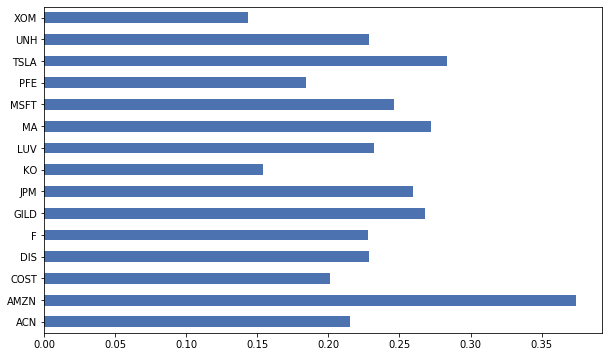

In [18]:
mu.plot.barh(figsize=(10,6));

## Long/short min variance

<!-- In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates how global-minimum variance (GMV) portfolios outperform mean-variance optimised portfolios. -->

이 섹션에서는 분산 최소화를 목적으로 롱/숏 포트폴리오를 구성합니다. GMV(global-minimum variance) 포트폴리오가 평균 분산 최적화 포트폴리오를 능가하는 방법을 보여주는 많은 연구가 있습니다.

In [19]:
from pypfopt import EfficientFrontier

In [20]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

/Users/hosung/anaconda3/envs/quantpython/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:112: UserWarning: No expected returns provided. You may only use ef.min_volatility()
  "No expected returns provided. You may only use ef.min_volatility()"


OrderedDict([('ACN', 0.23135),
             ('AMZN', 0.00782),
             ('COST', 0.09556),
             ('DIS', -0.01498),
             ('F', -0.01774),
             ('GILD', 0.03986),
             ('JPM', -0.05091),
             ('KO', 0.10889),
             ('LUV', 0.02433),
             ('MA', 0.24247),
             ('MSFT', 0.0042),
             ('PFE', 0.06255),
             ('TSLA', 0.16208),
             ('UNH', 0.02874),
             ('XOM', 0.07579)])

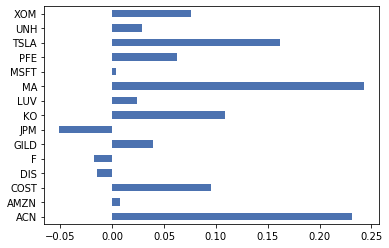

In [21]:
pd.Series(weights).plot.barh();

<!-- We can get a quick indication of the portfolio performance as follows. Note that this is an in sample estimate and may have very little resemblance to how the portfolio actually performs! -->

다음과 같이 포트폴리오 실적을 빠르게 확인할 수 있습니다. 이것은 샘플 추정치이며 포트폴리오가 실제로 수행되는 방식과 거의 유사하지 않을 수 있습니다!

In [22]:
ef.portfolio_performance(verbose=True);

Annual volatility: 11.7%


<!-- Let's say we were happy with this portfolio and wanted to actually go out and buy the shares.  To do this, we would need to construct a **discrete allocation** (unless your broker supports fractional shares!) -->

우리가 이 포트폴리오에 만족했고 실제로 나가서 주식을 사고 싶었다고 가정해 봅시다. 이를 위해서는 **개별 할당**<sup>discrete allocation</sup>을 구성해야합니다 (중개업자가 부분 지분을 지원하지 않는 한!).


<!-- If we had \$20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows: -->

투자 할 \$20,0000이 있고 포트폴리오가 130/30 롱/숏이되도록 하려면 실제 할당을 다음과 같이 구성 할 수 있습니다.

In [23]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $10.57 leftover


{'ACN': 18,
 'COST': 5,
 'GILD': 11,
 'KO': 41,
 'LUV': 12,
 'MA': 13,
 'PFE': 32,
 'TSLA': 6,
 'UNH': 2,
 'XOM': 35,
 'DIS': -8,
 'F': -186,
 'JPM': -37}

## Max Sharpe with sector constraints

<!-- If you have your own model for returns (or have read the warnings and want to proceed anyways), you may consider maximising the Sharpe ratio. This theoretically gives the optimal portfolio in terms of risks-returns. -->

수익률에 대한 자체 모델이 있거나 경고를 읽고 계속 진행하려는 경우 Sharpe 비율을 최대화하는 것을 고려할 수 있습니다. 이것은 이론적으로 위험-수익 측면에서 최적의 포트폴리오를 제공합니다.

<!-- In this section, we construct a long-only max-sharpe portfolio, but also incorporate sector constraints. Sector constraints require three things. A `sector_mapper`, your `sector_lower` bounds, and your `sector_upper` bounds. -->

이 섹션에서 우리는 롱-온리 전용 최대 샤프 포트폴리오를 구성하지만 섹터 제약도 포함합니다. 섹터 제약에는 세 가지가 필요합니다. `sector_mapper`, 당신의 `sector_lower` 경계, 그리고 당신의 `sector_upper` 경계.

In [24]:
sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto"
}

sector_lower = {
    "Consumer Staples": 0.1, # at least 10% to staples
    "Tech": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Tech": 0.2,
    "Aerospace":0.1,
    "Energy": 0.1,
    "Auto":0.15
}

<!-- We then set up the optimiser and add our constraints. We can use `ef.add_objective()` to add other constraints. For example, let's say that in addition to the above sector constraints, I specifically want:

- 10% of the portfolio in AMZN
- Less than 5% of my portfolio in TSLA -->

그런 다음 옵티 마이저를 설정하고 제약 조건을 추가합니다. `ef.add_objective()`를 사용하여 다른 제약 조건을 추가 할 수 있습니다. 예를 들어, 위의 섹터 제약외에도, 구체적으로 다음과 같은 것을 원한다고 가정 해 보겠습니다.

- AMZN 포트폴리오의 10%
- TSLA에서 포트폴리오의 5% 미만

In [25]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

amzn_index = ef.tickers.index("AMZN")
ef.add_constraint(lambda w: w[amzn_index] == 0.10)

tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.05)

ef.add_constraint(lambda w: w[10] >= 0.05)

ef.max_sharpe()
weights = ef.clean_weights()

In [26]:
weights

OrderedDict([('ACN', 0.17067),
             ('AMZN', 0.1),
             ('COST', 0.05544),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.05858),
             ('JPM', 0.0),
             ('KO', 0.04456),
             ('LUV', 0.01823),
             ('MA', 0.40389),
             ('MSFT', 0.05),
             ('PFE', 0.01781),
             ('TSLA', 0.05),
             ('UNH', 0.03081),
             ('XOM', 0.0)])

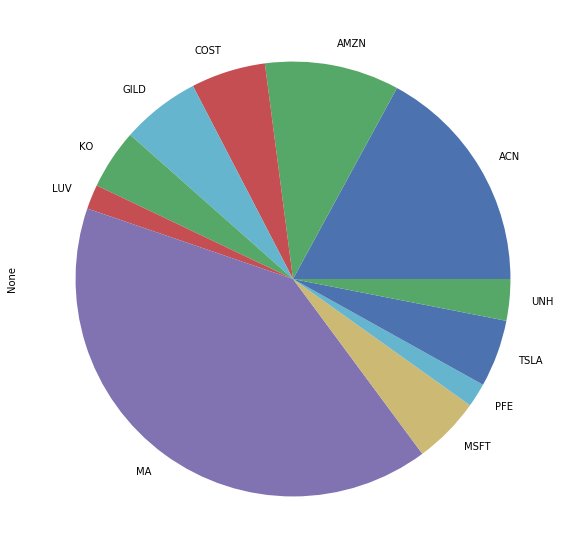

In [27]:
pd.Series(weights).plot.pie(figsize=(10,10));

<!-- We can immediately see that our explicit constraints were satisfied, and can check all the sector constraints as follows: -->

명시적 제약조건이 충족되었음을 즉시 확인할 수 있으며, 다음과 같이 모든 섹터 제약을 확인할 수 있습니다.


In [28]:
# O(N^2) loop not a good idea in a coding interview :)
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Tech: 0.050
Auto: 0.050
Aerospace: 0.018
Healthcare: 0.107
Consumer Discretionary: 0.100
Misc: 0.171
Financial Services: 0.404
Energy: 0.000
Media: 0.000
Consumer Staples: 0.100


## Maximise return for a given risk, with L2 regularisation
L2 정규화를 통해 주어진 리스크에 대한 수익 극대화
<!-- Let's imagine that we've put a lot of thought into our risk tolerance, and have decided that we can't accept anything more than 15% volatility. We can use PyPortfolioOpt to construct a portfolio that maximises return for a given risk (with the same caveats about expected returns). -->

위험 허용 범위에 대해 많은 고려를 했고 15% 이상의 변동성을 받아 들일 수 없다고 결정했다고 가정 해 봅시다. PyPortfolioOpt를 사용하여 주어진 위험에 대한 수익을 극대화하는 포트폴리오를 구성 할 수 있습니다(예상 수익에 대한 동일한 주의 사항 포함).

In [29]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.0),
             ('AMZN', 0.20605),
             ('COST', 0.1),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.05251),
             ('JPM', 0.0),
             ('KO', 0.0),
             ('LUV', 0.0),
             ('MA', 0.44144),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.0),
             ('XOM', 0.0)])

In [30]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

9/15 tickers have zero weight


In [31]:
ef.portfolio_performance(verbose=True);

Expected annual return: 28.6%
Annual volatility: 15.0%
Sharpe Ratio: 1.77


<!-- While this portfolio seems like it meets our objectives, we might be worried by the fact that a lot of the tickers have been assigned zero weight. In effect, the optimiser is "overfitting" to the data you have provided -- you are much more likely to get better results by enforcing some level of diversification. One way of doing this is to use **L2 regularisation** – essentially, adding a penalty on the number of near-zero weights. -->

이 포트폴리오가 우리의 목표를 충족하는 것처럼 보이지만 많은 티커에 0 가중치가 할당되어 있다는 사실에 대해 걱정할 수 있습니다. 실제로 옵티마이저는 제공한 데이터에 "과적합" 합니다. 일정 수준의 다각화를 적용하면 더 나은 결과를 얻을 가능성이 훨씬 더 높습니다. 이를 수행하는 한 가지 방법은 **L2 정규화**를 사용하는 것입니다. 기본적으로 0에 가까운 가중치의 수에 패널티를 추가합니다.

In [32]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.04475),
             ('AMZN', 0.21633),
             ('COST', 0.0897),
             ('DIS', 0.00607),
             ('F', 0.0),
             ('GILD', 0.08481),
             ('JPM', 0.04044),
             ('KO', 0.0103),
             ('LUV', 0.02332),
             ('MA', 0.25235),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.03193),
             ('XOM', 0.0)])

In [33]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

3/15 tickers have zero weight


<!-- We can tune the value of gamma to choose the number of nonzero tickers. Larger gamma pulls portfolio weights towards an equal allocation. -->

0이 아닌 티커 수를 선택하기 위해 gamma 값을 조정할 수 있습니다. gamma가 클수록 포트폴리오 가중치가 균등하게 할당됩니다.

In [34]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.05542),
             ('AMZN', 0.13456),
             ('COST', 0.06177),
             ('DIS', 0.06192),
             ('F', 0.0611),
             ('GILD', 0.08155),
             ('JPM', 0.0774),
             ('KO', 0.03823),
             ('LUV', 0.0637),
             ('MA', 0.08365),
             ('MSFT', 0.07076),
             ('PFE', 0.03973),
             ('TSLA', 0.0889),
             ('UNH', 0.0621),
             ('XOM', 0.01921)])

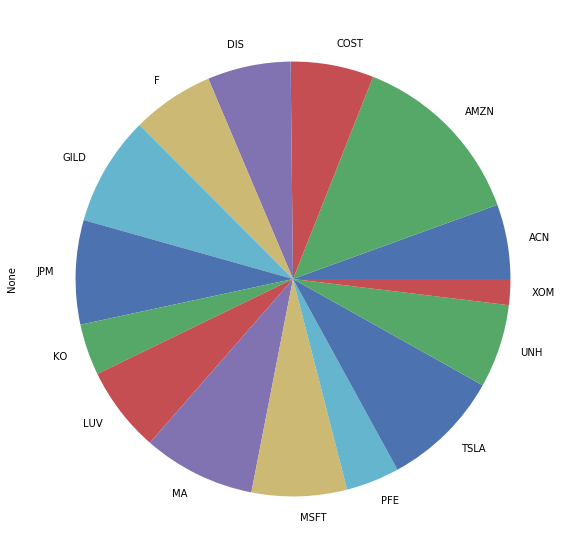

In [35]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [36]:
ef.portfolio_performance(verbose=True);

Expected annual return: 25.5%
Annual volatility: 14.8%
Sharpe Ratio: 1.59


<!-- The resulting portfolio still has a volatility of less than our 15% limit. It's in-sample Sharpe ratio has gone down, but this portfolio is a lot more robust for actual investment. -->

그 결과로 생긴 포트폴리오의 변동성은 여전히 15% 한도 미만입니다. 샘플 내 샤프 비율이 낮아졌지만 이 포트폴리오는 실제 투자에 훨씬 더 견고합니다.

## Minimise risk for a given return, market-neutral
주어진 수익, 시장 중립에 대한 위험 최소화

<!-- We may instead be in the situation where we have a certain required rate of return (maybe we are a pension fund that needs 7% return a year), but would like to minimise risk. Additionally, suppose we would like our portfolio to be market neutral, in the sense that it is equally exposed to the long and short sides.   -->

대신 우리는 특정 필수 수익률(연금 7% 수익률이 필요한 연금 기금 일 수도 있음)을 가지고 있지만 위험을 최소화하고자 할 수 있습니다. 또한, 우리의 포트폴리오가 롱숏측에 똑같이 노출된다는 점에서 시장 중립적이기를 원한다고 가정합니다.

In [37]:
# Must have no weight bounds to allow shorts
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_objective(objective_functions.L2_reg)
ef.efficient_return(target_return=0.07, market_neutral=True)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', -0.0329),
             ('AMZN', 0.21523),
             ('COST', -0.05492),
             ('DIS', -0.00632),
             ('F', -0.00842),
             ('GILD', 0.05086),
             ('JPM', 0.04187),
             ('KO', -0.12885),
             ('LUV', -0.00293),
             ('MA', 0.06363),
             ('MSFT', 0.01905),
             ('PFE', -0.07996),
             ('TSLA', 0.0812),
             ('UNH', -0.00746),
             ('XOM', -0.15008)])

In [38]:
ef.portfolio_performance(verbose=True);

Expected annual return: 7.0%
Annual volatility: 10.2%
Sharpe Ratio: 0.49


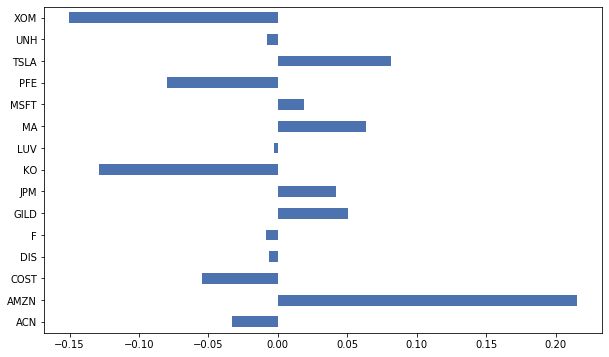

In [39]:
pd.Series(weights).plot.barh(figsize=(10,6));

In [40]:
print(f"Net weight: {sum(weights.values()):.2f}")

Net weight: 0.00


## Plotting

<!-- To plot the unconstrained efficient frontier, we can use the critical line algorithm.  -->

제한되지 않은 효율적인 프론티어를 플로팅하기 위해 임계선 알고리즘을 사용할 수 있습니다.

In [41]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 26.0%
Annual volatility: 12.5%
Sharpe Ratio: 1.92


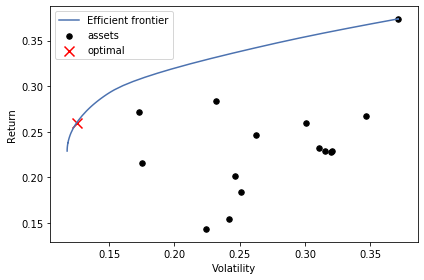

In [42]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

<!-- PyPortfolioOpt does not yet suport plotting the constrained efficient frontier (i.e based on `EfficientFrontier` objects). Such support may arrive in a future version. It is possible to do this manually by looping over portfolios: -->

PyPortfolioOpt는 제한된 효율적인 프론티어 (즉, `EfficientFrontier` 객체를 기반으로 함) 플로팅을 아직 지원하지 않습니다. 이러한 지원은 향후 버전에 포함될 수 있습니다. 포트폴리오를 반복하여 수동으로 수행 할 수 있습니다.

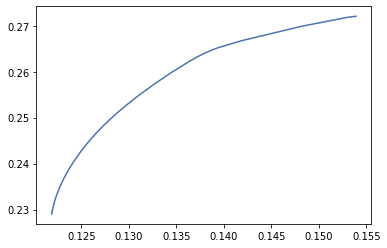

In [43]:
returns, sigmas = [], []
for delta in np.arange(1, 100, 1):
    ef = EfficientFrontier(mu, S, weight_bounds=(0.02, 0.15))
    ef.max_quadratic_utility(delta)
    ret, sigma, _ = ef.portfolio_performance()
    returns.append(ret)
    sigmas.append(sigma)
plt.plot(sigmas, returns);